In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc

import numpy as np
import pandas as pd
import torch
import torchio as tio
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from einops import rearrange
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from research.scripts.bigbigan import *

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
dataset_path = Path('D:\\Datasets\\NSD\\')
derivatives_path = dataset_path / 'derivatives'
betas_path = dataset_path / 'nsddata_betas' / 'ppdata'
ppdata_path = dataset_path / 'nsddata' / 'ppdata'

In [3]:
model_name = 'bigbigan-resnet50'# ResNet-50
#model_name = 'bigbigan-revnet50x4' # RevNet-50 x4
module_path = f'https://tfhub.dev/deepmind/{model_name}/1'

# module = hub.Module(module_path, trainable=True, tags={'train'})  # training
module = hub.Module(module_path)  # inference

for signature in module.get_signature_names():
    print('Signature:', signature)
    print('Inputs:', pformat(module.get_input_info_dict(signature)))
    print('Outputs:', pformat(module.get_output_info_dict(signature)))
    print()

Signature: discriminate
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>,
 'z': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}
Outputs: {'score_x': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_xz': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_z': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>}

Signature: encode
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}
Outputs: {'avepool_feat': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>,
 'bn_crelu_feat': <hub.ParsedTensorInfo shape=(?, 4096) dtype=float32 is_sparse=False>,
 'default': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>,
 'z_mean': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>,
 'z_sample': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>,
 'z_stdev': <hub.ParsedTensorInf

In [4]:
bigbigan = BigBiGAN(module)

# Make input placeholders for x (`enc_ph`) and z (`gen_ph`).
enc_ph = bigbigan.make_encoder_ph()
gen_ph = bigbigan.make_generator_ph()

# Compute samples G(z) from encoder input z (`gen_ph`).
gen_samples = bigbigan.generate(gen_ph)

# Compute reconstructions G(E(x)) of encoder input x (`enc_ph`).
recon_x = bigbigan.reconstruct_x(enc_ph, upsample=True)

# Compute encoder features used for representation learning evaluations given
# encoder input x (`enc_ph`).
enc_features = bigbigan.encode(enc_ph, return_all_features=True)

# Compute discriminator scores for encoder pairs (x, E(x)) given x (`enc_ph`)
# and generator pairs (G(z), z) given z (`gen_ph`).
disc_scores_enc = bigbigan.discriminate(*bigbigan.enc_pairs_for_disc(enc_ph))
disc_scores_gen = bigbigan.discriminate(*bigbigan.gen_pairs_for_disc(gen_ph))

# Compute losses.
losses = bigbigan.losses(enc_ph, gen_ph)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [ ]:
feed_dict = {gen_ph: np.random.randn(12, 120)}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

In [6]:
subjects = {f'subj0{i}': {} for i in range(1, 9)}

for subject_name, subject_data in subjects.items():
    responses_file_path = ppdata_path / subject_name / 'behav' / 'responses.tsv'
    subject_data['responses'] = pd.read_csv(responses_file_path, sep='\t',)
    
    # The last 3 sessions are currently held-out for the algonauts challenge
    # remove them for now.
    session_ids = subject_data['responses']['SESSION']
    held_out_mask = session_ids > (np.max(session_ids) - 3)
    subject_data['responses'] = subject_data['responses'][~held_out_mask]

In [7]:
stimulu_path = dataset_path / 'nsddata_stimuli' / 'stimuli' / 'nsd' / 'nsd_stimuli.hdf5'
stimulus_images = h5py.File(stimulu_path, 'r')['imgBrick']

subject_name = 'subj01'

num_voxels = 2500

split_name = 'split-01'
split = h5py.File(derivatives_path / 'data_splits' / f'{split_name}.hdf5')
subject_split = split[subject_name]
test_mask = subject_split['test_response_mask'][:].astype(bool)
validation_mask = subject_split['validation_response_mask'][:].astype(bool)
validation_indices = np.where(validation_mask)[0]
training_mask = ~(test_mask | validation_mask)
training_indices = np.where(training_mask)[0]
responses = subjects[subject_name]['responses']
training_stimulus_ids = responses['73KID'].to_numpy()[training_indices] - 1
validation_stimulus_ids = responses['73KID'].to_numpy()[validation_indices] - 1

X_val = np.stack([
    stimulus_images[i] 
    for i in validation_stimulus_ids
])

In [8]:
X_val.shape

(3000, 425, 425, 3)

In [9]:
embedding_model = 'bigbigan-resnet50'
embedding_key = 'z_mean'
code_name = 'sanitycheck'
version = '3-0'

in_path = derivatives_path / 'decoded_features' / embedding_model / embedding_key / subject_name
Z_val_pred = np.load(in_path / f'Y_val_pred__{code_name}__v{version}.npy')
Z_val = np.load(in_path / f'Y_val__{code_name}__v{version}.npy')

In [11]:
Z_val_pred[:, 1].std()

0.051335074

In [20]:
from scipy import ndimage, misc
from PIL import Image

out_path = derivatives_path / 'results' / embedding_model / embedding_key / code_name / version / subject_name
out_path.mkdir(exist_ok=True, parents=True)

def make_images(x, z, z_pred):
    num_samples = 13
    z_pred_mean = z_pred[0]
    z_pred_std = z_pred[1]
    sample = np.random.randn(num_samples, z_pred_mean.shape[0])
    z_pred = z_pred_mean[None, :] + z_pred_std[None, :] * sample

    x_pred = sess.run(gen_samples, feed_dict={gen_ph: z_pred})
    x_recon = sess.run(gen_samples, feed_dict={gen_ph: z[None]})
    x = ndimage.zoom(x, (128 / x.shape[0], 128 / x.shape[1], 1))
    x = x / 256 * 2 - 1

    out = np.concatenate([x[None], x_recon, x_pred])

    img = imgrid(image_to_uint8(out), cols=5)
    return img

def save_images(X, Z, Z_pred):
    for i in tqdm(range(X.shape[0])):
        img = make_images(X[i], Z[i], Z_pred[i])
        Image.fromarray(img).save(out_path / f'img{i:04}.png')
        
def view_images(X, Z, Z_pred):
    @interact(i=(0, X_val.shape[0]-1), scale=(0., 2.))
    def show(i, scale):
        z = Z_pred[i] * scale
        #print(z[0].std())
        img = make_images(X[i], Z[i], z)
        
        plt.figure(figsize=(12, 12))
        plt.imshow(img)
    
view_images(X_val, Z_val, Z_val_pred)

interactive(children=(IntSlider(value=1499, description='i', max=2999), FloatSlider(value=1.0, description='sc…

samples shape: (12, 128, 128, 3)


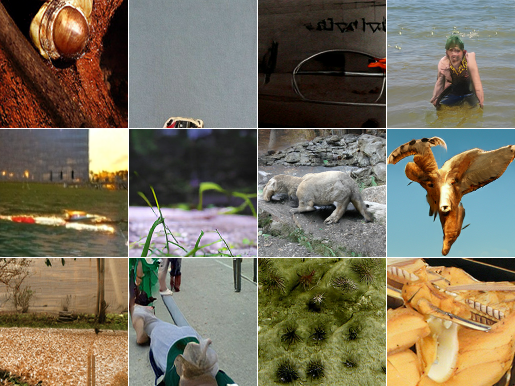

In [13]:
feed_dict = {gen_ph: np.random.randn(12, 120)}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

In [14]:
_out_samples.shape

(12, 128, 128, 3)